In [6]:
import torch.utils.data as data
from PIL import Image
import os


class GetLoader(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data



from torch.autograd import Function


class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None




import torch.nn as nn



class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(50 * 4 * 4, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(50 * 4 * 4, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        # print("I am in forward")
        # print(input_data.data.shape[0])
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

    
import os
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision import transforms

from torchvision import datasets


def test(dataset_name):
    #assert dataset_name in ['MNIST', 'mnist_m']

    model_root = ''
    image_root = os.path.join('dataset', dataset_name)

    cuda = True
    cudnn.benchmark = True
    batch_size = 128
    image_size = 28
    alpha = 0

    """load data"""

    img_transform_source = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    img_transform_target = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

    if dataset_name == 'mnist_m':
        test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')

        dataset = GetLoader(
            data_root=os.path.join(image_root, 'mnist_m_test'),
            data_list=test_list,
            transform=img_transform_target
        )
    else:
        dataset = datasets.MNIST(
            root='dataset',
            train=False,
            transform=img_transform_source,
        )

    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8
    )

    """ test """

    my_net = torch.load(os.path.join(
        model_root, 'mnist_mnistm_model_epoch_current.pth'
    ))
    my_net = my_net.eval()

    if cuda:
        my_net = my_net.cuda()

    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0

    while i < len_dataloader:

        # test model using target data
        data_target = next(data_target_iter)
        t_img, t_label = data_target

        batch_size = len(t_label)

        if cuda:
            t_img = t_img.cuda()
            t_label = t_label.cuda()

        class_output, _ = my_net(input_data=t_img, alpha=alpha)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(t_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total

    return accu


In [ ]:
import random
import os
import sys
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import numpy as np

from torchvision import datasets
from torchvision import transforms



source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
print(source_image_root)
target_image_root = os.path.join('dataset', target_dataset_name)
print(target_image_root)
model_root = 'models'
cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 5

manual_seed = random.randint(1, 10000)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# load data

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset_source = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

# print("dataloader_source.shape")
# print(dataloader_source.shape())

train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')

dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

# load model

# print("dataloader_target.shape")
# print(dataloader_target.shape())

my_net = CNNModel()

# setup optimizer

optimizer = optim.Adam(my_net.parameters(), lr=lr)

loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()

for p in my_net.parameters():
    p.requires_grad = True

# training
best_accu_t = 0.0

accList = []
errList = []

for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    for i in range(len_dataloader):

        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        data_source = next(data_source_iter)
        s_img, s_label = data_source
        
        # print('\n')
        # print(s_img.shape)
        # print(s_label)

        my_net.zero_grad()
        batch_size = len(s_label)

        domain_label = torch.zeros(batch_size).long()

        if cuda:
            s_img = s_img.cuda()
            s_label = s_label.cuda()
            domain_label = domain_label.cuda()


        class_output, domain_output = my_net(input_data=s_img, alpha=alpha)
        
        
        print("jdsjfs")
        print(class_output)
        print(s_label)
        err_s_label = loss_class(class_output, s_label)
        err_s_domain = loss_domain(domain_output, domain_label)

        # training model using target data
        data_target = next(data_target_iter)
        t_img, _ = data_target
        
        
        # print('\n I am in targert')
        # print(t_img.shape)
        # print(_)

        batch_size = len(t_img)

        domain_label = torch.ones(batch_size).long()

        if cuda:
            t_img = t_img.cuda()
            domain_label = domain_label.cuda()

        _, domain_output = my_net(input_data=t_img, alpha=alpha)
        err_t_domain = loss_domain(domain_output, domain_label)
        err = err_t_domain + err_s_domain + err_s_label
        err.backward()
        optimizer.step()
        
        errList.append(err)

        sys.stdout.write('\r epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
              % (epoch, i + 1, len_dataloader, err_s_label.data.cpu().numpy(),
                 err_s_domain.data.cpu().numpy(), err_t_domain.data.cpu().item()))
        sys.stdout.flush()
        torch.save(my_net, 'mnist_mnistm_model_epoch_current.pth'.format(model_root))

    print('\n')
    accu_s = test(source_dataset_name)
    print('Accuracy of the %s dataset: %f' % ('mnist', accu_s))
    accu_t = test(target_dataset_name)
    print('Accuracy of the %s dataset: %f\n' % ('mnist_m', accu_t))
    accList.append([accu_s,accu_t])
    if accu_t > best_accu_t:
        best_accu_s = accu_s
        best_accu_t = accu_t
        
        
        
        torch.save(my_net, 'mnist_mnistm_model_epoch_best.pth'.format(model_root))

print('============ Summary ============= \n')
print('Accuracy of the %s dataset: %f' % ('mnist', best_accu_s))
print('Accuracy of the %s dataset: %f' % ('mnist_m', best_accu_t))
print('Corresponding model was save in ' + model_root + 'mnist_mnistm_model_epoch_best.pth')

dataset/MNIST
dataset/mnist_m
jdsjfs
tensor([[-3.0898, -2.1266, -2.8985,  ..., -1.9743, -2.4832, -2.5274],
        [-2.4320, -2.2871, -2.6083,  ..., -2.4085, -2.4901, -2.2575],
        [-2.8476, -1.8366, -2.0967,  ..., -2.2690, -2.7209, -2.4463],
        ...,
        [-2.7563, -2.3758, -2.1207,  ..., -2.3476, -1.9762, -2.5962],
        [-3.1333, -2.8563, -2.5385,  ..., -1.4769, -2.8843, -1.7786],
        [-2.3305, -2.4953, -2.0764,  ..., -2.0799, -2.4810, -1.8409]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([5, 2, 8, 9, 1, 6, 6, 9, 9, 7, 2, 7, 9, 3, 0, 1, 1, 1, 9, 1, 1, 3, 2, 2,
        4, 7, 6, 0, 1, 8, 4, 0, 6, 1, 6, 3, 1, 7, 2, 2, 8, 1, 4, 7, 9, 3, 3, 9,
        8, 4, 4, 4, 6, 7, 8, 8, 4, 0, 3, 1, 1, 1, 4, 5, 4, 3, 8, 0, 8, 6, 8, 0,
        3, 3, 6, 4, 9, 0, 3, 0, 1, 6, 6, 9, 7, 7, 8, 1, 2, 4, 1, 0, 1, 4, 5, 9,
        6, 6, 4, 7, 8, 2, 2, 3, 9, 8, 4, 9, 3, 9, 6, 9, 6, 1, 5, 3, 9, 1, 3, 4,
        3, 2, 4, 2, 4, 6, 3, 3], device='cuda:0')
 epoch: 0, [iter: 1 / al

In [33]:













# import numpy as np

# for i in range(len(errList)):
#     errList[i] = errList[i].data.cpu().numpy()

eRRs = []
for i in range(len(errList)):
    eRRs.append(errList[i])

ValueError: x and y must have same first dimension, but have shapes (100,) and (46100,)

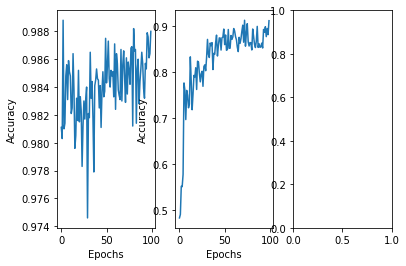

In [28]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = [i for i in range(100)]


fig = plt.figure()

# total_rows, total_columns, subplot_index(1st, 2nd, etc..)
plt.subplot(1, 3, 1)
plt.plot(xpoints, acc_s_List)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(xpoints, acc_t_List)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(xpoints, eRRs)
plt.xlabel('Epochs')
plt.ylabel('Error')
